# ML Assignment 2
Patrick Keogh
19321326

In [1]:
# Standard library imports
import os
import warnings
from itertools import combinations_with_replacement

# Third-party imports for data processing and analysis
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets, svm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_selection import chi2, mutual_info_classif, SelectKBest
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, confusion_matrix, 
                             ConfusionMatrixDisplay, f1_score, precision_score, 
                             recall_score, RocCurveDisplay)
from sklearn.model_selection import (GridSearchCV, KFold, RepeatedStratifiedKFold, 
                                     StratifiedKFold, cross_validate, train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# MLxtend imports for feature selection and plotting
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# Configuring warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ConvergenceWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Magic function for inline plot display
%matplotlib inline

In [2]:
# Read in data from csv file to pandas dataframe.
df = pd.read_csv('census_19321326.csv')
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,Income-category
0,43,Local-gov,115603,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
1,21,Private,275190,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,<=50K
2,43,?,174662,Some-college,10,Divorced,?,Not-in-family,White,Female,0,0,40,United-States,<=50K
3,26,Private,417941,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,62,Self-emp-inc,197060,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,20,?,346341,Some-college,10,Never-married,?,Not-in-family,White,Female,0,0,35,United-States,<=50K
9996,24,Private,69640,Bachelors,13,Never-married,Sales,Own-child,White,Male,0,0,40,United-States,<=50K
9997,33,Private,142383,Assoc-acdm,12,Never-married,Sales,Not-in-family,Other,Male,0,0,36,United-States,<=50K
9998,26,State-gov,58039,Some-college,10,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,<=50K


## Question 1

In [3]:
df = df.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               10000 non-null  int64 
 1    workclass        10000 non-null  object
 2    fnlwgt           10000 non-null  int64 
 3    education        10000 non-null  object
 4    education-num    10000 non-null  int64 
 5    marital-status   10000 non-null  object
 6    occupation       10000 non-null  object
 7    relationship     10000 non-null  object
 8    race             10000 non-null  object
 9    sex              10000 non-null  object
 10   capital-gain     10000 non-null  int64 
 11   capital-loss     10000 non-null  int64 
 12   hours-per-week   10000 non-null  int64 
 13   native-country   10000 non-null  object
 14   Income-category  10000 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.1+ MB


In [5]:
# Clean the column names
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.replace('-', '_')
df.columns = [col.lower() for col in df.columns]
for col in df.select_dtypes(["object"]):
    df[col] = df[col].str.strip()
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'income_category'],
      dtype='object')

In [6]:
# drop any duplicate records
df.drop_duplicates(keep='first', inplace=True)
df

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_category
0,43,Local-gov,115603,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
1,21,Private,275190,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,<=50K
2,43,?,174662,Some-college,10,Divorced,?,Not-in-family,White,Female,0,0,40,United-States,<=50K
3,26,Private,417941,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K
4,62,Self-emp-inc,197060,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,20,?,346341,Some-college,10,Never-married,?,Not-in-family,White,Female,0,0,35,United-States,<=50K
9996,24,Private,69640,Bachelors,13,Never-married,Sales,Own-child,White,Male,0,0,40,United-States,<=50K
9997,33,Private,142383,Assoc-acdm,12,Never-married,Sales,Not-in-family,Other,Male,0,0,36,United-States,<=50K
9998,26,State-gov,58039,Some-college,10,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,United-States,<=50K


In [7]:
# % of missing data for all features
100 * (df.isnull().sum())

age                0
workclass          0
fnlwgt             0
education          0
education_num      0
marital_status     0
occupation         0
relationship       0
race               0
sex                0
capital_gain       0
capital_loss       0
hours_per_week     0
native_country     0
income_category    0
dtype: int64

There appears to be no missing data, however, in the above dataframe we can see that there is a '?' value in some of the columns. We will treat these as missing values and remove the rows where they are present.

In [8]:
# List of columns that contain '?' in at least one of their cells
columns_with_question_mark = []
for col in df.columns:
    if (df[col].astype(str).str.contains('\?')).any():
        columns_with_question_mark.append(col)

# Print out the list of those columns
print("Columns containing '?':", columns_with_question_mark)

Columns containing '?': ['workclass', 'occupation', 'native_country']


In [9]:
#Replace all '?' with NaN
df.replace('?', np.nan, inplace=True)
num_rows_with_null = df.isnull().any(axis=1).sum()
num_rows_with_null

751

As there are not too many rows with null values, we can just drop them

In [10]:
df.dropna(inplace=True)

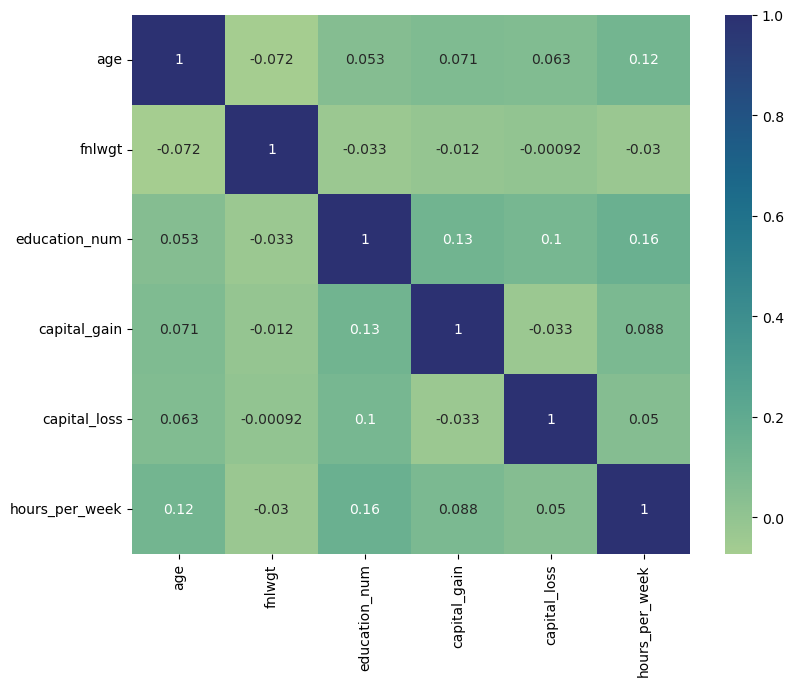

In [11]:
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Draw a feature correlation plot
plt.figure(figsize=(9, 7))
sns.heatmap(data=numeric_df.corr(), annot=True, cmap="crest")
plt.show()

We can clearly see that the column 'fnlwgt' has negative correlation with all other variables, so we can just drop it.

In [12]:
df.drop(columns="fnlwgt", inplace=True)

In [13]:
df.nunique()

age                69
workclass           7
education          16
education_num      16
marital_status      7
occupation         14
relationship        6
race                5
sex                 2
capital_gain       91
capital_loss       69
hours_per_week     84
native_country     41
income_category     2
dtype: int64

Based of this we can see that the target class income_category and the sex column can be converted to binary variables and education and education_num essentially detail the same information, so one of them can be dropped. In this case, I will choose to keep education_num as a number value is easier to work with. 

We can also check the other categorical columns to check if there is a column with a clearly dominant value that can then also be converted to a binary variable. 

In [14]:
def convert_to_binary(column, one_value):
    for value in list(column.unique()):
        if value == one_value:
            column = column.replace(value, 1)
        else:
            column = column.replace(value, 0)
    return column

In [15]:
df.income_category = convert_to_binary(df.income_category,'>50K')
df.sex = convert_to_binary(df.sex, 'Female')

In [16]:
# Convert target class and sex column to a binary variable
df.sex = df.sex.replace('Female', 1)
df.sex = df.sex.replace('Male', 0)
df

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_category
0,43,Local-gov,Some-college,10,Divorced,Adm-clerical,Unmarried,White,1,0,0,40,United-States,0
1,21,Private,Some-college,10,Never-married,Sales,Own-child,White,1,0,0,20,United-States,0
3,26,Private,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,1,0,0,40,United-States,0
4,62,Self-emp-inc,Assoc-voc,11,Married-civ-spouse,Exec-managerial,Husband,White,0,0,0,50,United-States,0
5,19,Private,12th,8,Never-married,Sales,Own-child,White,1,0,0,18,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,23,Private,Bachelors,13,Never-married,Sales,Not-in-family,White,0,0,0,25,United-States,0
9996,24,Private,Bachelors,13,Never-married,Sales,Own-child,White,0,0,0,40,United-States,0
9997,33,Private,Assoc-acdm,12,Never-married,Sales,Not-in-family,Other,0,0,0,36,United-States,0
9998,26,State-gov,Some-college,10,Married-civ-spouse,Other-service,Husband,White,0,0,0,40,United-States,0


In [17]:
df.drop(columns="education", inplace=True)

In [18]:
def print_unique_value_counts(df, column_name):
    if column_name in df.columns:
        value_counts = df[column_name].value_counts()
        print(f"Counts of unique values in '{column_name}':\n{value_counts}")
    else:
        print(f"Column '{column_name}' not found in the DataFrame.")

In [19]:
print_unique_value_counts(df, 'workclass')

Counts of unique values in 'workclass':
workclass
Private             6836
Self-emp-not-inc     750
Local-gov            654
State-gov            392
Self-emp-inc         333
Federal-gov          278
Without-pay            5
Name: count, dtype: int64


In [20]:
print_unique_value_counts(df, 'marital_status')

Counts of unique values in 'marital_status':
marital_status
Married-civ-spouse    4299
Never-married         3075
Divorced              1255
Separated              274
Widowed                238
Married-spouse-abs      98
Married-AF-spouse        9
Name: count, dtype: int64


In [21]:
print_unique_value_counts(df, 'occupation')

Counts of unique values in 'occupation':
occupation
Craft-repair         1274
Prof-specialty       1238
Exec-managerial      1200
Adm-clerical         1127
Sales                1116
Other-service         979
Machine-op-inspct     582
Transport-moving      486
Handlers-cleaners     426
Farming-fishing       310
Tech-support          282
Protective-serv       193
Priv-house-serv        34
Armed-Forces            1
Name: count, dtype: int64


In [22]:
print_unique_value_counts(df, 'relationship')

Counts of unique values in 'relationship':
relationship
Husband           3847
Not-in-family     2317
Own-child         1428
Unmarried          983
Wife               404
Other-relative     269
Name: count, dtype: int64


In [23]:
print_unique_value_counts(df, 'race')

Counts of unique values in 'race':
race
White                 7992
Black                  829
Asian-Pac-Islander     273
Amer-Indian-Eskimo      93
Other                   61
Name: count, dtype: int64


In [24]:
print_unique_value_counts(df, 'native_country')

Counts of unique values in 'native_country':
native_country
United-States            8419
Mexico                    188
Philippines                67
Canada                     37
Germany                    33
El-Salvador                33
Cuba                       33
India                      31
Puerto-Rico                29
Jamaica                    29
England                    24
China                      23
Vietnam                    20
Columbia                   20
Haiti                      19
South                      19
Poland                     18
Dominican-Republic         18
Japan                      18
Guatemala                  18
Italy                      17
Nicaragua                  16
Portugal                   15
Taiwan                     12
Greece                     12
Hong                        9
Peru                        8
Iran                        8
Ireland                     8
Ecuador                     8
Trinadad&Tobago             6
Outlying-U

Based on these findings, we can see that condense some of the column categories. I will convert the race column to a binary variable representing White vs POC and the native_country to a binary variable representing US vs non-US country of origin.

I will convert the workclass column to a simpler three category column of government employed (gov), self-employed(self-employed) and private.

The marital status, occupation and relationship columns do not have categories that are overly dominant, so I will leave them as they are, but apply one-hot encoding. 

In [25]:
df.race = convert_to_binary(df.race, 'White')
df.native_country = convert_to_binary(df.native_country, 'United-States')

In [26]:
def categorize_workclass(row):
    if row['workclass'] in ['Local-gov', 'State-gov', 'Federal-gov']:
        return 'gov'
    elif row['workclass'] in ['Self-emp-not-inc', 'Self-emp-inc', 'Without-pay']:
        return 'self-employed'
    elif row['workclass'] == 'Private':
        return 'private'

In [27]:
df['workclass'] = df.apply(categorize_workclass, axis=1)
df['workclass'].value_counts()

workclass
private          6836
gov              1324
self-employed    1088
Name: count, dtype: int64

In [28]:
categorical_columns = ['marital_status', 'occupation', 'relationship','workclass']
df = pd.concat([df.drop(columns=categorical_columns), 
                pd.get_dummies(df[categorical_columns], 
                prefix=categorical_columns)],axis=1)
bool_columns = df.select_dtypes(include=['bool']).columns
df[bool_columns] = df[bool_columns].astype(int)

In [29]:
# Clean the column names again
df.columns = df.columns.str.replace(' ', '')
df.columns = df.columns.str.replace('-', '_')
df.columns = [col.lower() for col in df.columns]
for col in df.select_dtypes(["object"]):
    df[col] = df[col].str.strip()
df.columns

Index(['age', 'education_num', 'race', 'sex', 'capital_gain', 'capital_loss',
       'hours_per_week', 'native_country', 'income_category',
       'marital_status_divorced', 'marital_status_married_af_spouse',
       'marital_status_married_civ_spouse',
       'marital_status_married_spouse_abs', 'marital_status_never_married',
       'marital_status_separated', 'marital_status_widowed',
       'occupation_adm_clerical', 'occupation_armed_forces',
       'occupation_craft_repair', 'occupation_exec_managerial',
       'occupation_farming_fishing', 'occupation_handlers_cleaners',
       'occupation_machine_op_inspct', 'occupation_other_service',
       'occupation_priv_house_serv', 'occupation_prof_specialty',
       'occupation_protective_serv', 'occupation_sales',
       'occupation_tech_support', 'occupation_transport_moving',
       'relationship_husband', 'relationship_not_in_family',
       'relationship_other_relative', 'relationship_own_child',
       'relationship_unmarried', 'r

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9248 entries, 0 to 9999
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   age                                9248 non-null   int64
 1   education_num                      9248 non-null   int64
 2   race                               9248 non-null   int64
 3   sex                                9248 non-null   int64
 4   capital_gain                       9248 non-null   int64
 5   capital_loss                       9248 non-null   int64
 6   hours_per_week                     9248 non-null   int64
 7   native_country                     9248 non-null   int64
 8   income_category                    9248 non-null   int64
 9   marital_status_divorced            9248 non-null   int64
 10  marital_status_married_af_spouse   9248 non-null   int64
 11  marital_status_married_civ_spouse  9248 non-null   int64
 12  marital_status_married_sp

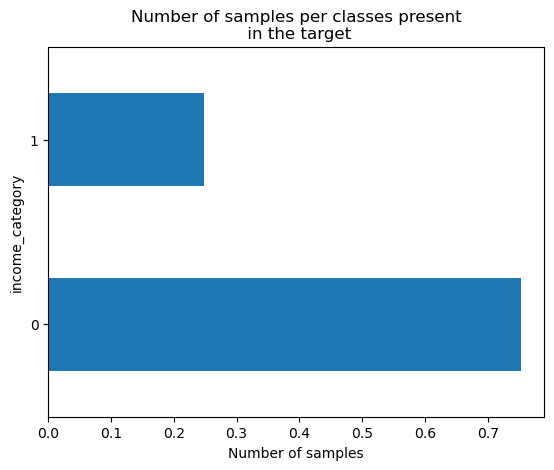

In [31]:
X = df.drop("income_category", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, df.income_category, random_state=1, test_size=0.25)
y_train.value_counts(normalize=True).plot.barh()
plt.xlabel("Number of samples")
plt.title("Number of samples per classes present\n in the target");

Traditional evaluation metrics like accuracy can be misleading when dealing with imbalanced datasets. In such cases, metrics that take into account the balance between classes, like balanced accuracy and the F1 score, are more appropriate. 

Balanced Accuracy
Definition: Balanced accuracy calculates the average of recall obtained on each class. It's particularly useful when dealing with imbalanced datasets.
Usefulness: It gives equal weight to both classes, which is useful when one class is significantly underrepresented.

F1 Score
Definition: The F1 score is the harmonic mean of precision and recall. It conveys the balance between the precision and the recall.
Usefulness: The F1 score is more informative than accuracy, especially if you have an uneven class distribution. It works well if false positives and false negatives have a similar cost.

In [32]:
classifier = DecisionTreeClassifier(random_state=5)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

balanced_acc = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='binary')  # or 'macro'/'weighted' for multiclass

print("Balanced Accuracy:", balanced_acc)
print("F1 Score:", f1)

Balanced Accuracy: 0.7561348419474885
F1 Score: 0.6402116402116403


As we can see the score for balanced accuracy is the highest, so we will go with that for our evaluation.

### Part (b)

In [33]:
def evaluate_classifier(classifier, param_grid):
    grid = GridSearchCV(classifier, param_grid, scoring="balanced_accuracy", cv=5, verbose=1, n_jobs=-1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_

    print(f"\nBest: {best}")
    print(f"Balanced_accuracy: {grid.best_score_:.3f}\n")
    return best

In [34]:
dt_param_grid = {"criterion": ["gini", "entropy"], 'max_depth': [1, 2, 3], 'min_samples_leaf': range(1, 11)}
dt_tuned = evaluate_classifier(DecisionTreeClassifier(random_state=0), dt_param_grid)

Fitting 5 folds for each of 60 candidates, totalling 300 fits

Best: DecisionTreeClassifier(max_depth=3, min_samples_leaf=3, random_state=0)
Balanced_accuracy: 0.737



In [35]:
def generate_hidden_layer_sizes(max_nodes, max_layers):
    combinations = []
    for layer_count in range(1, max_layers + 1):
        for combo in combinations_with_replacement(range(1, max_nodes + 1), layer_count):
            if sum(combo) <= max_nodes:
                combinations.append(combo)
    return combinations
combinations = generate_hidden_layer_sizes(max_nodes=10, max_layers=3)

In [36]:
# Neural Network (Note: from my previous evaluation I discovered (4,6) was the best size 
# so I have decided to remove the combinations list I used orginally to speed things up for correction)
nn_param_grid = {'hidden_layer_sizes': [(10,),(4,6),(5,5)], "activation": ["logistic", "tanh", "relu"],}
nn_tuned = evaluate_classifier(MLPClassifier(max_iter=1000, random_state=0), nn_param_grid)

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best: MLPClassifier(hidden_layer_sizes=(4, 6), max_iter=1000, random_state=0)
Balanced_accuracy: 0.775



In [37]:
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)
knn_param_grid = {
    "leaf_size": [1, 2, 5, 10, 15, 20, 25, 30],
    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]
}

knn_tuned = evaluate_classifier(KNeighborsClassifier(n_neighbors=1, n_jobs=-1), knn_param_grid)

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best: KNeighborsClassifier(leaf_size=1, metric='manhattan', n_jobs=-1, n_neighbors=1)
Balanced_accuracy: 0.750



We have now tuned the best parameters for further study and can see that the Neural network performs the best for this dataset.

### Part (c)

In [38]:
def evaluate_ensemble_size(classifier, X_train, X_test, y_train, y_test, ensemble_sizes=range(2, 21, 2)):
    best_balanced_accuracy = 0
    best_ensemble_size = 0

    # Initialise a list to store results
    results = []

    for size in ensemble_sizes:
        bagging_model = BaggingClassifier(classifier, n_estimators=size, bootstrap=True, random_state=1)
        bagging_model.fit(X_train, y_train)
        predictions = bagging_model.predict(X_test)
        balanced_accuracy = balanced_accuracy_score(y_test, predictions)

        # Append results to the list
        results.append({
            'n_estimators': size,
            'balanced_accuracy': balanced_accuracy
        })

        # Update best values
        if balanced_accuracy > best_balanced_accuracy:
            best_balanced_accuracy = balanced_accuracy
            best_ensemble_size = size

    # Convert the results list to a DataFrame
    results_df = pd.DataFrame(results)

    # Convert the best parameters into a DataFrame
    best_params = pd.DataFrame({
        '': ['Best n_estimators', 'Best Balanced_accuracy'],
        ' ': [int(best_ensemble_size), best_balanced_accuracy]
    })
    best_params.set_index('', inplace=True)

    return results_df, best_params

In [39]:
results_df, best_params = evaluate_ensemble_size(dt_tuned, X_train, X_test, y_train, y_test)
results_df

,n_estimators,balanced_accuracy
0,2,0.749926
1,4,0.749073
2,6,0.746513
3,8,0.746513
4,10,0.746513
5,12,0.746513
6,14,0.746513
7,16,0.746513
8,18,0.747366
9,20,0.746513


In [40]:
best_params

,
,
Best n_estimators,2.000000
Best Balanced_accuracy,0.749926


In [41]:
results_df, best_params = evaluate_ensemble_size(nn_tuned, X_train, X_test, y_train, y_test)
results_df

,n_estimators,balanced_accuracy
0,2,0.776929
1,4,0.792883
2,6,0.786057
3,8,0.775591
4,10,0.775865
5,12,0.784398
6,14,0.783271
7,16,0.773032
8,18,0.780147
9,20,0.782981


In [42]:
best_params

,
,
Best n_estimators,4.000000
Best Balanced_accuracy,0.792883


In [43]:
results_df, best_params = evaluate_ensemble_size(knn_tuned, X_train, X_test, y_train, y_test)
results_df

,n_estimators,balanced_accuracy
0,2,0.747692
1,4,0.758995
2,6,0.768849
3,8,0.771072
4,10,0.776755
5,12,0.780200
6,14,0.783902
7,16,0.781874
8,18,0.783581
9,20,0.782712


In [44]:
best_params

,
,
Best n_estimators,14.000000
Best Balanced_accuracy,0.783902


#### Decision Tree
- n_estimators: 2
- Balanced accuracy: 0.74993

#### Neural Network
- n_estimators: 4
- Balanced accuracy: 0.79288

#### KNN
- n_estimators: 14
- Balanced accuracy: 0.78390

### Part (d)

In [45]:
def best_ensemble_and_subspace_size(classifier, X_train, X_test, y_train, y_test, ensemble_sizes=range(2, 21, 2), feature_fractions=[0.25, 0.5, 0.75, 1.0]):
    best_score = 0
    best_ensemble_size = 0
    best_feature_fraction = 0

    # Initialize a dictionary to store results
    results = {e_size: {} for e_size in ensemble_sizes}

    for ensemble_size in ensemble_sizes:
        for feature_fraction in feature_fractions:
            bagging_classifier = BaggingClassifier(
                base_estimator=classifier, 
                n_estimators=ensemble_size, 
                max_features=feature_fraction, 
                bootstrap=True, 
                random_state=1
            )
            bagging_classifier.fit(X_train, y_train)
            predictions = bagging_classifier.predict(X_test)
            score = balanced_accuracy_score(y_test, predictions)

            # Store the results in the dictionary
            results[ensemble_size][feature_fraction] = score

            # Update best parameters if the current score is better
            if score > best_score:
                best_score = score
                best_ensemble_size = ensemble_size
                best_feature_fraction = feature_fraction

    # Convert the results dictionary to a DataFrame
    results_df = pd.DataFrame(results)

    # Information about the best parameters
    best_params = pd.DataFrame({
        '': ['Best n_estimators', 'Best max_features', 'Best Balanced_accuracy'],
        ' ': [best_ensemble_size, best_feature_fraction, best_score]
    })
    best_params.set_index('', inplace=True)
    
    return results_df, best_params

In [46]:
results_df, best_params = best_ensemble_and_subspace_size(dt_tuned, X_train, X_test, y_train, y_test)
results_df

,2,4,6,8,10,12,14,16,18,20
0.25,0.629456,0.672923,0.675820,0.639821,0.631900,0.650639,0.611164,0.619986,0.614866,0.633622
0.50,0.677995,0.730896,0.728626,0.734873,0.739139,0.738286,0.733730,0.730896,0.728626,0.733456
0.75,0.745644,0.743695,0.744822,0.744822,0.743953,0.746513,0.746513,0.746513,0.746513,0.745949
1.00,0.749926,0.749073,0.746513,0.746513,0.746513,0.746513,0.746513,0.746513,0.747366,0.746513


In [47]:
best_params

,
,
Best n_estimators,2.000000
Best max_features,1.000000
Best Balanced_accuracy,0.749926


In [48]:
results_df, best_params = best_ensemble_and_subspace_size(nn_tuned, X_train, X_test, y_train, y_test)
results_df

,2,4,6,8,10,12,14,16,18,20
0.25,0.622050,0.685917,0.689088,0.663311,0.645183,0.654811,0.642317,0.637551,0.629598,0.633301
0.50,0.736126,0.764162,0.761634,0.760523,0.753986,0.758268,0.755998,0.731333,0.735600,0.743858
0.75,0.624752,0.733504,0.737691,0.754403,0.754950,0.762919,0.772837,0.771999,0.778230,0.775670
1.00,0.776929,0.792883,0.786057,0.775591,0.775865,0.784398,0.783271,0.773032,0.780147,0.782981


In [49]:
best_params

,
,
Best n_estimators,4.000000
Best max_features,1.000000
Best Balanced_accuracy,0.792883


In [50]:
results_df, best_params = best_ensemble_and_subspace_size(knn_tuned, X_train, X_test, y_train, y_test)
results_df

,2,4,6,8,10,12,14,16,18,20
0.25,0.568459,0.624020,0.667714,0.661336,0.629729,0.656375,0.654473,0.691969,0.699374,0.720078
0.50,0.658360,0.686227,0.725766,0.745148,0.755451,0.752038,0.752859,0.762566,0.751732,0.769150
0.75,0.679191,0.710861,0.741641,0.750447,0.759301,0.784350,0.775465,0.774949,0.775528,0.783802
1.00,0.747692,0.758995,0.768849,0.771072,0.776755,0.780200,0.783902,0.781874,0.783581,0.782712


In [51]:
best_params

,
,
Best n_estimators,12.00000
Best max_features,0.75000
Best Balanced_accuracy,0.78435


#### Decision Tree
- n_estimators: 2
- max features: 1
- Balanced accuracy: 0.74993

#### Neural Network
- n_estimators: 4
- max features: 1
- Balanced accuracy: 0.79288

#### KNN
- n_estimators: 12
- max features: 0.75
- Balanced accuracy: 0.78435

### Part (e)

From the our lectures, we expect that classifiers with inherent instability, like decision trees and neural networks, are more likely to gain performance enhancements from bagging techniques as opposed to random subspacing ensembles. This is the oppposite to more stable classifiers, such as k-Nearest Neighbors (kNN), where it has been consistently observed that the application of random subspacing methods can lead to more notable improvements in their performance.

In [52]:
scores =[['Decision Tree',0.737,0.74993,0.74993],['Neural Network',0.768,0.79288,0.79288],
        ['K-Nearest Neighbours',0.750,0.78390,0.78435]]
df_scores = pd.DataFrame(scores, columns=['Classifier', 'Tuned', 'Bagged', 'Subspace'])

In [53]:
df_scores

,Classifier,Tuned,Bagged,Subspace
0,Decision Tree,0.737,0.74993,0.74993
1,Neural Network,0.768,0.79288,0.79288
2,K-Nearest Neighbours,0.750,0.78390,0.78435


In our analysis of the dataset, we observed the following:

- **Decision Trees**: Theis model demonstrated significant improvement with bagging techniques. However, applying random subspacing did not yield any changes in performance.
- **Neural Networks**: Similar to the Decision Tree, the neural network model showed a large improvement when bagged, but random subspacing had no impact.
- **K-Nearest Neighbors (kNN)**: This model showed some improvement with bagging, but it improved notably with random subspacing.

Tuning benefitted all the models significantly and the Neural Network model performd the best across all tests. Overall, these results align well with our initial expectations.

#### Areas for Improvement:

- **Diversity in Ensembles**: The current ensembles might lack sufficient diversity. It is important to note that measuring ensemble diversity definitively is challenging.
- **Exploring Additional Ensemble Strategies**: To further enhance ensemble performance, considering a larger number of estimators for both bagging and random subspacing could be beneficial. Moreover, exploring boosting ensemble methods such as Random Forest, AdaBoost, and Gradient Boosting could be of interest in order to see their suitability for this dataset.
- **Balancing Trade-offs in Ensemble Construction**: When constructing ensemble classifiers, it is vital to balance trade-offs. This includes managing the trade-off between accuracy and ensemble diversity, as well as between bias and variance, to optimize model performance.


## Question 2

In [55]:
import gymnasium
from gymnasium import spaces
import torch as th
import stable_baselines3 as sb3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import DQN, PPO, A2C
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
from IPython.display import display, HTML

### Part (a)

### State Representation
- **Balls State**: A list representing the position of each ball, initially all in bin number 5: [5, 5, 5, 5, 5, 5, 5, 5, 5, 5].
- **Bin State**: A list indicating the count of balls in each bin, starting as [0, 0, 0, 0, 0, 10, 0, 0, 0, 0].

### Action Space 

Each ball has three possible actions: 
- Move to the left (Bb - 1)
- Move to the right (Bb + 1) 
- Stay in the current bin (Bb)

Moves to the left or right are only allowed if they keep the ball within the bins range [0, 9].

### Reward Mechanism
- **Ideal State Reward**: Achieving the target state (each bin containing exactly one ball) yields a high reward, such as 100 points.
- **Movement Rewards** 
    - **Move Left**:
        If a ball is already at the leftmost bin (position 0), it cannot move further left.
        A ball can move left if the adjacent left bin is empty or if it helps in achieving a more balanced distribution.
        Greater rewards are given for moves that lead to a faster approach to the ideal state. For example, moving left might receive a higher reward (like 50 points) if there are more empty bins on the left than on the right, and a lower reward (like 25 points) otherwise.
    - **Move Right**:
        Similar to 'Move Left', but with the boundary condition at the rightmost bin (position 9).
        The reward structure mirrors that of moving left, adjusted for rightward movement.
    - **Stay**:
        A smaller reward (like 15 points) is given if the ball is already in an optimal position, either at a boundary or in a bin that contributes to the ideal distribution.
        However, a penalty can be added to prevent the odel getting stuck on a ball

### Episode Termination
- An episode concludes successfully with a 'done' signal when the ideal state is reached.
- Consideration for a maximum number of steps per episode could be added to avoid overly long episodes.

### Part (b)

In [56]:
class CustomEnv(gymnasium.Env):
    metadata = {'render.modes': ['console']}
    
    def __init__(self):
        super(CustomEnv, self).__init__()
        self.bins  = [0, 0, 0, 0, 0, 10, 0, 0, 0, 0]
        self.balls  = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
        self.ball_id = 0
        self.previous_ball_id = None
        self.consecutive_actions = 0
        self.previous_position = None
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.MultiDiscrete([10] * 10)
        
    def step(self, action):
        if self.bins == [1,1,1,1,1,1,1,1,1,1]:
            done = True
            reward = 100
        else:
            reward = 0
            done = False
   
        # Move Left
        if action == 0: 
            if self.balls[self.ball_id] != 0:
                if (self.bins[self.balls[self.ball_id]-1] == 0) | (sum(self.bins[:self.balls[self.ball_id]]) < self.balls[self.ball_id]):
                    if self.bins[:self.balls[self.ball_id]].count(0) > self.bins[self.balls[self.ball_id]+1:].count(0):
                        reward = 50
                    else:
                        reward = 25
                    self.bins[self.balls[self.ball_id]] -= 1
                    self.bins[self.balls[self.ball_id]-1] += 1
                    self.balls[self.ball_id] -= 1
                if (self.balls[self.ball_id] == self.previous_position) & (self.ball_id == self.previous_ball_id):
                    reward -= 10  # Penalty for staying in the same position
                    
        # Move Right
        elif action == 1: 
            if self.balls[self.ball_id] != 9:
                if (self.bins[self.balls[self.ball_id]+1] == 0) | (sum(self.bins[self.balls[self.ball_id]+1:]) < self.balls[self.ball_id]-1):
                    if self.bins[:self.balls[self.ball_id]].count(0) < self.bins[self.balls[self.ball_id]+1:].count(0):
                        reward = 50
                    else:
                        reward = 25
                    self.bins[self.balls[self.ball_id]] -= 1
                    self.bins[self.balls[self.ball_id]+1] += 1
                    self.balls[self.ball_id] += 1
            if (self.balls[self.ball_id] == self.previous_position) & (self.ball_id == self.previous_ball_id):
                reward -= 10  # Penalty for staying in the same position
        # Stay
        elif action == 2:
            if (self.balls[self.ball_id] == 0):
                reward = 15
            elif (self.balls[self.ball_id] == 9):
                reward = 15
            elif ((self.bins[self.balls[self.ball_id]-1] == 1) & (sum(self.bins[:self.balls[self.ball_id]]) == self.balls[self.ball_id])):
                reward = 15
            elif ((self.bins[self.balls[self.ball_id]+1] == 1) & (sum(self.bins[self.balls[self.ball_id]+1:]) == self.balls[self.ball_id]-1)):
                reward = 15
            if (self.balls[self.ball_id] == self.previous_position) & (self.ball_id == self.previous_ball_id):
                reward -= 15  # Penalty for staying in the same position
        
       
        self.previous_position = self.balls[self.ball_id]
        self.previous_ball_id = self.ball_id     
        
                                                                   
        if self.bins[self.balls[self.ball_id]] == 1:
            if self.ball_id < 9:
                self.ball_id += 1

       
        if self.bins == [1,1,1,1,1,1,1,1,1,1]:
            done = True
            reward = 100
        
        observation = np.array(self.balls)
        truncated = done
        return observation, reward, done, truncated, {}
    
    def reset(self, seed=0):
        self.bins = [0, 0, 0, 0, 0, 10, 0, 0, 0, 0]
        self.balls = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
        self.ball_id = 0
        self.previous_position = None
        self.stay_count = 0
        return np.array(self.balls), {}
    
    def render(self, mode='human'):
        # Display the current state of the bins and balls
        print(f"Current ball under consideration, {self.previous_ball_id + 1} is now  at position {self.balls[self.previous_ball_id]}")
        print(f"Bin distribution after move: {self.bins}")
        print(f"Positions of the balls after move: {self.balls}")
        
        if self.bins != [1,1,1,1,1,1,1,1,1,1]:
            print(f"Next ball under consideration, {self.ball_id+1} is at position {self.balls[self.ball_id]}")
        print("\n")
        
    def close(self):
        pass
check_env(CustomEnv(), warn=True)

### Part (c)

In [57]:
env = CustomEnv()

In [58]:
def run_model_in_env(env, model, max_steps=30):
    obs, _ = env.reset()
    step = 0
    for i in range(max_steps):
        action, _ = model.predict(obs, deterministic=True)
        print("Step {}".format(step + 1))
        print("Action: ", action)

        obs, reward, done, truncated, info = env.step(action)
        print('obs =', obs, 'reward =', reward, 'done =', done, 'truncated =', truncated)
        env.render(mode='console')

        if done:
            print("Goal achieved, ", "reward =", reward)
            break

        step += 1

### 50000 episodes

In [235]:
model = PPO('MlpPolicy', env, verbose=0).learn(50000)

In [236]:
run_model_in_env(env, model)
del model

Step 1
Action:  0
obs = [4 5 5 5 5 5 5 5 5 5] reward = 50 done = False truncated = False
Current ball under consideration, 1 is now  at position 4
Bin distribution after move: [0, 0, 0, 0, 1, 9, 0, 0, 0, 0]
Positions of the balls after move: [4, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 5


Step 2
Action:  0
obs = [4 4 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 4
Bin distribution after move: [0, 0, 0, 0, 2, 8, 0, 0, 0, 0]
Positions of the balls after move: [4, 4, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 4


Step 3
Action:  0
obs = [4 3 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 3
Bin distribution after move: [0, 0, 0, 1, 1, 8, 0, 0, 0, 0]
Positions of the balls after move: [4, 3, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 3 is at position 5


Step 4
Action:  0
obs = [

In [237]:
model = DQN('MlpPolicy', env, verbose=0).learn(50000)

In [238]:
run_model_in_env(env, model)
del model

Step 1
Action:  1
obs = [6 5 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 1 is now  at position 6
Bin distribution after move: [0, 0, 0, 0, 0, 9, 1, 0, 0, 0]
Positions of the balls after move: [6, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 5


Step 2
Action:  1
obs = [6 6 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 6
Bin distribution after move: [0, 0, 0, 0, 0, 8, 2, 0, 0, 0]
Positions of the balls after move: [6, 6, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 6


Step 3
Action:  1
obs = [6 7 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 7
Bin distribution after move: [0, 0, 0, 0, 0, 8, 1, 1, 0, 0]
Positions of the balls after move: [6, 7, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 3 is at position 5


Step 4
Action:  1
obs = [

In [239]:
model = A2C('MlpPolicy', env, verbose=0).learn(50000)

In [240]:
run_model_in_env(env, model)
del model

Step 1
Action:  1
obs = [6 5 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 1 is now  at position 6
Bin distribution after move: [0, 0, 0, 0, 0, 9, 1, 0, 0, 0]
Positions of the balls after move: [6, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 5


Step 2
Action:  1
obs = [6 6 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 6
Bin distribution after move: [0, 0, 0, 0, 0, 8, 2, 0, 0, 0]
Positions of the balls after move: [6, 6, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 6


Step 3
Action:  1
obs = [6 7 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 7
Bin distribution after move: [0, 0, 0, 0, 0, 8, 1, 1, 0, 0]
Positions of the balls after move: [6, 7, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 3 is at position 5


Step 4
Action:  1
obs = [

### 100000 episodes

In [241]:
model = PPO('MlpPolicy', env, verbose=0).learn(100000)

In [242]:
run_model_in_env(env, model)
del model

Step 1
Action:  1
obs = [6 5 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 1 is now  at position 6
Bin distribution after move: [0, 0, 0, 0, 0, 9, 1, 0, 0, 0]
Positions of the balls after move: [6, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 5


Step 2
Action:  1
obs = [6 6 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 6
Bin distribution after move: [0, 0, 0, 0, 0, 8, 2, 0, 0, 0]
Positions of the balls after move: [6, 6, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 6


Step 3
Action:  1
obs = [6 7 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 7
Bin distribution after move: [0, 0, 0, 0, 0, 8, 1, 1, 0, 0]
Positions of the balls after move: [6, 7, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 3 is at position 5


Step 4
Action:  1
obs = [

In [243]:
model = DQN('MlpPolicy', env, verbose=0).learn(100000)

In [244]:
run_model_in_env(env, model)
del model

Step 1
Action:  0
obs = [4 5 5 5 5 5 5 5 5 5] reward = 50 done = False truncated = False
Current ball under consideration, 1 is now  at position 4
Bin distribution after move: [0, 0, 0, 0, 1, 9, 0, 0, 0, 0]
Positions of the balls after move: [4, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 5


Step 2
Action:  0
obs = [4 4 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 4
Bin distribution after move: [0, 0, 0, 0, 2, 8, 0, 0, 0, 0]
Positions of the balls after move: [4, 4, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 4


Step 3
Action:  0
obs = [4 3 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 3
Bin distribution after move: [0, 0, 0, 1, 1, 8, 0, 0, 0, 0]
Positions of the balls after move: [4, 3, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 3 is at position 5


Step 4
Action:  0
obs = [

In [245]:
model = A2C('MlpPolicy', env, verbose=0).learn(100000)

In [246]:
run_model_in_env(env, model)
del model

Step 1
Action:  0
obs = [4 5 5 5 5 5 5 5 5 5] reward = 50 done = False truncated = False
Current ball under consideration, 1 is now  at position 4
Bin distribution after move: [0, 0, 0, 0, 1, 9, 0, 0, 0, 0]
Positions of the balls after move: [4, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 5


Step 2
Action:  0
obs = [4 4 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 4
Bin distribution after move: [0, 0, 0, 0, 2, 8, 0, 0, 0, 0]
Positions of the balls after move: [4, 4, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 4


Step 3
Action:  0
obs = [4 3 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 3
Bin distribution after move: [0, 0, 0, 1, 1, 8, 0, 0, 0, 0]
Positions of the balls after move: [4, 3, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 3 is at position 5


Step 4
Action:  0
obs = [

### 200000 episodes

In [247]:
model = PPO('MlpPolicy', env, verbose=0).learn(200000)

In [248]:
run_model_in_env(env, model)
del model

Step 1
Action:  0
obs = [4 5 5 5 5 5 5 5 5 5] reward = 50 done = False truncated = False
Current ball under consideration, 1 is now  at position 4
Bin distribution after move: [0, 0, 0, 0, 1, 9, 0, 0, 0, 0]
Positions of the balls after move: [4, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 5


Step 2
Action:  0
obs = [4 4 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 4
Bin distribution after move: [0, 0, 0, 0, 2, 8, 0, 0, 0, 0]
Positions of the balls after move: [4, 4, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 4


Step 3
Action:  0
obs = [4 3 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 3
Bin distribution after move: [0, 0, 0, 1, 1, 8, 0, 0, 0, 0]
Positions of the balls after move: [4, 3, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 3 is at position 5


Step 4
Action:  0
obs = [

In [249]:
model = DQN('MlpPolicy', env, verbose=0).learn(200000)

In [250]:
run_model_in_env(env, model)
del model

Step 1
Action:  1
obs = [6 5 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 1 is now  at position 6
Bin distribution after move: [0, 0, 0, 0, 0, 9, 1, 0, 0, 0]
Positions of the balls after move: [6, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 5


Step 2
Action:  1
obs = [6 6 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 6
Bin distribution after move: [0, 0, 0, 0, 0, 8, 2, 0, 0, 0]
Positions of the balls after move: [6, 6, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 6


Step 3
Action:  1
obs = [6 7 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 7
Bin distribution after move: [0, 0, 0, 0, 0, 8, 1, 1, 0, 0]
Positions of the balls after move: [6, 7, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 3 is at position 5


Step 4
Action:  1
obs = [

In [251]:
model = A2C('MlpPolicy', env, verbose=0).learn(200000)

In [252]:
run_model_in_env(env, model)
del model
env.close()

Step 1
Action:  0
obs = [4 5 5 5 5 5 5 5 5 5] reward = 50 done = False truncated = False
Current ball under consideration, 1 is now  at position 4
Bin distribution after move: [0, 0, 0, 0, 1, 9, 0, 0, 0, 0]
Positions of the balls after move: [4, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 5


Step 2
Action:  0
obs = [4 4 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 4
Bin distribution after move: [0, 0, 0, 0, 2, 8, 0, 0, 0, 0]
Positions of the balls after move: [4, 4, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 2 is at position 4


Step 3
Action:  0
obs = [4 3 5 5 5 5 5 5 5 5] reward = 25 done = False truncated = False
Current ball under consideration, 2 is now  at position 3
Bin distribution after move: [0, 0, 0, 1, 1, 8, 0, 0, 0, 0]
Positions of the balls after move: [4, 3, 5, 5, 5, 5, 5, 5, 5, 5]
Next ball under consideration, 3 is at position 5


Step 4
Action:  0
obs = [

**PPQ**

Steps to complete:
- 50,000 - 25 steps
- 100,000 - 25 steps 
- 200,000 - 25 steps

The **Proximal Policy Optimization(PPQ)** algorithm  focuses on directly optimising the expected reward. It achieves this by estimating the gradient of the policy based on the agent's trajectories. This method is predominantly online, relying on the most recent transitions made by the agent to inform policy updates.

**DQN**

Steps to complete:
- 50,000 - did not reach desired state
- 100,000 - 25 steps 
- 200,000 - did not reach desired state

The **Deep Q-Network (DQN)** is a value-iteration methodology. This technique does not optimise for the reward directly. Instead, it is centred on developing a function approximator. This approximator is designed to predict Q-values that align with the recursive Bellman Equation. Subsequently, the most optimal actions are identified based on which action maximises the Q-value. This method is offline, involving the storage of transitions in a buffer. These are then randomly sampled to facilitate the updating of the Q-value approximator.

**A2C**

Steps to complete:
- 50,000 - 25 steps
- 100,000 - 25 steps 
- 200,000 - 25 steps

In **actor-critic** methods, a dual approach is employed. The 'critic' network assesses the value of a given state, whereas the 'actor' directly seeks to optimise the expected reward.
The **Advantage Actor-Critic (A2C)** model expands upon this concept. It incorporates multiple agents that learn in parallel, with their updates occurring asynchronously.

**PPO** and **A2C** are generally more sample efficient than **DQN**. They can learn more effectively from a smaller number of interactions with the environment converge to a good policy faster. This explains their better performance at 50,000 episodes, however they do take longer to train.
**DQN** generally requires more samples to learn effectively, which could be why it performs well at 100,000 episodes but not at lower episodes.

Additionally, the low performance seen on 200000 episodes for the **DQN** model may be due to overfitting. Overfitting occurs when the model becomes too attuned to the specifics of the training data, losing its generalization capability and performing poorly on unseen data or scenarios. 
This problem may also be more suitable for policy gradient methods (PPO, A2C) than for a value-based method like **DQN**.

As both **PPO** and **A2C** perform equally well, I will select **A2C** for the next part, as it runs slightly faster on my machine than **PPO**. 

### Part (d)

In [324]:
class TimeLimitWrapper(gymnasium.Wrapper):
    def __init__(self, env, max_steps):
        super().__init__(env)
        self.max_steps = max_steps
        self.current_step = 0

    def reset(self, **kwargs):
        self.current_step = 0
        return self.env.reset(**kwargs)

    def step(self, action):
        self.current_step += 1
        obs, reward, done, truncated, info = self.env.step(action)
        if self.current_step >= self.max_steps:
            done = True
        return obs, reward, done, truncated, info

In [334]:
env = CustomEnv()
wrapped_env = TimeLimitWrapper(env, max_steps=30)

In [335]:
def train_evaluate(env, model_architecture, episodes):
    model = A2C("MlpPolicy", env, policy_kwargs=model_architecture, verbose=0).learn(episodes)
    mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
    print(f"Architecture: {model_architecture['net_arch']}\nMean Reward: {mean_reward}\nStd: {std_reward}")

In [336]:
architectures = [
    dict(net_arch=[64, 64, 64]),  # 3 layers of 64 neurons each
    dict(net_arch=[32, 32]),      # 2 layers of 32 neurons each
    dict(net_arch=[16]),          # 1 layer of 16 neurons
    dict(net_arch=[2])            # 1 layer of 2 neurons
]

# Train and evaluate each architecture
display(HTML('<b>10000 Episodes</b>'))
for arch in architectures:
    train_evaluate(wrapped_env, arch, 10000)

display(HTML('<b>50000 Episodes</b>'))
for arch in architectures:
    train_evaluate(wrapped_env, arch, 50000)

display(HTML('<b>100000 Episodes</b>'))
for arch in architectures:
    train_evaluate(wrapped_env, arch, 100000)

env.close()
wrapped_env.close()

Architecture: [64, 64, 64]
Mean Reward: 950.0
Std: 0.0
Architecture: [32, 32]
Mean Reward: 950.0
Std: 0.0
Architecture: [16]
Mean Reward: 260.0
Std: 0.0
Architecture: [2]
Mean Reward: 260.0
Std: 0.0


Architecture: [64, 64, 64]
Mean Reward: 950.0
Std: 0.0
Architecture: [32, 32]
Mean Reward: 950.0
Std: 0.0
Architecture: [16]
Mean Reward: 950.0
Std: 0.0
Architecture: [2]
Mean Reward: 950.0
Std: 0.0


Architecture: [64, 64, 64]
Mean Reward: 950.0
Std: 0.0
Architecture: [32, 32]
Mean Reward: 950.0
Std: 0.0
Architecture: [16]
Mean Reward: 950.0
Std: 0.0
Architecture: [2]
Mean Reward: 950.0
Std: 0.0


### Analysis of RL Model Performance across different architectures

The results from training the reinforcement learning models over various episode counts with different neural network architectures reveal several key insights:

**Performance Across Architectures (10,000 Episodes)**:
   - Complex architectures ([64, 64, 64] and [32, 32]) achieve a mean reward of 950.0 i.e. reach the desired state with minimal steps.
   - Simpler architectures ([16] and [2]) reach a mean reward of only 60.0 i.e. do not reach the desired state.
   - This suggests a need for model complexity in the initial learning phase.


**Improvement with Increased Training**:
   - At 50,000 and 100,000 episodes, all architectures, including simpler ones, achieve a mean reward of 950.0.
   - Indicates that with more training, simpler models can learn effectively.


**Model Complexity vs. Training Duration**:
   - The improvement in simpler models ([16] and [2]) with increased training episodes highlights a trade-off: simpler models may require more time to converge to an effective strategy.


**Ceiling Effect**:
   - The consistent mean reward of 950.0, along with a standard deviation of 0.0, suggests a ceiling effect in the environment's reward structure or that the best possible method for achieving the task result in that reward.


**Conclusions**:
   - Even minimal architectures are sufficient for this task, however sufficient training is needed for low numbers of neurons and layers. 